In [51]:
from itertools import chain
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
import torch

def rgb_to_bgr(image):
    b, g, r = cv2.split(image)
    image = cv2.merge([r, g, b])
    return image


In [4]:
folder_dir = '/opt/ml/input/data/train/images'
folder_name = os.listdir(folder_dir)
folder_name = sorted([x for x in folder_name if '._' not in x]) # '._' 제거

file_list = [[folder_name[i]+"/"+file for file in os.listdir(os.path.join(folder_dir,folder_name[i])) if '._' not in file and 'ipynb' not in file] for i in range(len(folder_name))]

# 모든 이미지명 리스트
all_file_list = list(chain(*file_list))

# class별 이미지명 리스트
incorrect_img = [os.path.join(folder_dir, file) for file in all_file_list if 'incorrect_mask' in file]
normal_img = [os.path.join(folder_dir, file) for file in all_file_list if 'normal' in file]
mask_img = [os.path.join(folder_dir, file) for file in all_file_list if 'incorrect_mask' not in file and 'normal' not in file]

incorrect_img = [file for file in incorrect_img if 'crop' not in file.split('/')[-1]]
normal_img = [file for file in normal_img if 'crop' not in file.split('/')[-1]]
mask_img = [file for file in mask_img if 'crop' not in file.split('/')[-1]]


print('모든 이미지 수: ', len(all_file_list))
print('incorrect 이미지 수: ', len(incorrect_img))
print('normal 이미지 수: ', len(normal_img))
print('mask 이미지 수: ', len(mask_img))
print('각 list 예시: ',incorrect_img[0], normal_img[0], mask_img[0], sep='\n')

모든 이미지 수:  21579
incorrect 이미지 수:  2700
normal 이미지 수:  2700
mask 이미지 수:  13500
각 list 예시: 
/opt/ml/input/data/train/images/000001_female_Asian_45/incorrect_mask.jpg
/opt/ml/input/data/train/images/000001_female_Asian_45/normal.jpg
/opt/ml/input/data/train/images/000001_female_Asian_45/mask3.jpg


### SSD object detector (상반신)

In [5]:
import torch
ssd_model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd')
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd_processing_utils')

ssd_model.to('cuda')
ssd_model.eval()

Using cache found in /opt/ml/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/opt/ml/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/opt/ml/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
Using cache found in /opt/ml/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


SSD300(
  (feature_extractor): ResNet(
    (feature_extractor): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplac

In [67]:
def face_cropping_top(image_list, batch_size):
    fail = []
    last = int(len(image_list) // batch_size)+1
    tt_x, tt_y, tt_w, tt_h = 0, 0, 0, 0
    torch.cuda.empty_cache()

    for turn in range(1, last+1):
        if turn == last:
            inputs = [utils.prepare_input(file) for file in image_list[(turn-1)*batch_size:]]
            print("last turn!")
        else:
            inputs = [utils.prepare_input(file) for file in image_list[(turn-1)*batch_size:turn*batch_size]]
            print("turn {}, {}".format(turn, len(inputs)))
                    
        tensor = utils.prepare_tensor(inputs)

        with torch.no_grad():
            detections_batch = ssd_model(tensor)

        results_per_input = utils.decode_results(detections_batch)
        best_results_per_input = [utils.pick_best(results, 0.40) for results in results_per_input]


        for image_idx in range(len(best_results_per_input)):
            # Show original, denormalized image...
            image = inputs[image_idx] / 2 + 0.5
            
            # ...with detections
            bboxes, classes, confidences = best_results_per_input[image_idx]
            img_info = image_list[image_idx+((turn-1)*batch_size)]
            img_path, img_name = '/'.join(img_info.split('/')[:-1]), img_info.split('/')[-1]
            src, dst = img_name.split('.')
            
            
            left, bot, right, top = bboxes[0]
            x, y, w, h = [val * 300 for val in [left, bot, right - left, top - bot]]
            detected_face_ = image[int(y):int(y+h), int(x):int(x+w)]
            
            try:
                detected_face_ = rgb_to_bgr(255*detected_face_)    
                # cv2.imwrite(os.path.join(img_path, src+"_cropped_top."+dst), detected_face_)
                tt_x += x
                tt_y += y
                tt_w += w
                tt_h += h
            except:
                x, y, w, h = [11.0, 30.0, 283.0, 271.0]
                crop_face_ = image[int(y):int(y+h), int(x):int(x+w)]
                crop_face_ = rgb_to_bgr(255*crop_face_)
                cv2.imwrite(os.path.join(img_path, src+"_cropped_top."+dst), crop_face_)
                fail.append(img_info)
    
    tt_x = (tt_x//((len(image_list)-len(fail))))
    tt_y = (tt_y//((len(image_list)-len(fail))))
    tt_w = (tt_w//((len(image_list)-len(fail))))
    tt_h = (tt_h//((len(image_list)-len(fail))))
    region = [tt_x, tt_y, tt_w, tt_h]
    
    return region, fail
                    

In [68]:
avg_region, fail = face_cropping_top(incorrect_img, 512)

turn 1, 512
turn 2, 512
turn 3, 512
turn 4, 512
turn 5, 512
last turn!


In [40]:
fail_df = pd.DataFrame(fail, columns=['fail'])
fail_df['mask_type'] = 'incorrect'
print(len(fail_df))
fail_df.head()

49


,fail,mask_type
0,/opt/ml/input/data/train/images/000534_female_...,incorrect
1,/opt/ml/input/data/train/images/000538_male_As...,incorrect
2,/opt/ml/input/data/train/images/000561_female_...,incorrect
3,/opt/ml/input/data/train/images/000591_female_...,incorrect
4,/opt/ml/input/data/train/images/000735_female_...,incorrect


In [44]:
x, y, w, h = avg_region
print(x, y, w, h)

11.0 30.0 283.0 271.0


In [41]:
fail[0]

'/opt/ml/input/data/train/images/000534_female_Asian_50/incorrect_mask.jpg'

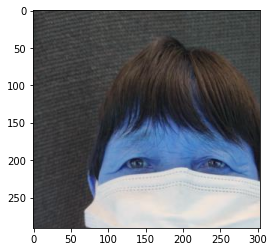

In [58]:
x, y, w, h = [11.0, 30.0, 283.0, 271.0]


In [46]:

for img_info in fail:
    # Show original, denormalized image...
    image = cv2.imread(img_info)
    
    img_path, img_name = '/'.join(img_info.split('/')[:-1]), img_info.split('/')[-1]
    src, dst = img_name.split('.')
    
    x, y, w, h = avg_region
    detected_face_ = image[int(y):int(y+h), int(x):int(x+w)]
    
    cv2.imwrite(os.path.join(img_path, src+"_cropped_top."+dst), detected_face_)
    
            

In [23]:
print(x, y, w, h)

4.886305332183838 60.13520658016205 281.31251335144043 240.2378797531128


In [ ]:
ssd_model.to('cuda')
ssd_model.eval()

In [39]:
# !pip install GPUtil

  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=ac970910b9c7dfbba50e9f1d0bdc42870482837011a7a9ffb8dd246a154aa523
  Stored in directory: /opt/ml/.cache/pip/wheels/ba/03/bb/7a97840eb54479b328672e15a536e49dc60da200fb21564d53
Successfully built GPUtil


In [47]:
import GPUtil
import gc
GPUtil.showUtilization()


| ID | GPU | MEM |
------------------
|  0 |  0% | 98% |


In [46]:
import gc
gc.collect()
gc.get_count()

(25, 0, 0)

In [38]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 7            |        cudaMalloc retries: 7         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |    4221 MB |    4749 MB |    8621 MB |    4399 MB |\n|       from large pool |    4200 MB |    4728 MB |    8557 MB |    4357 MB |\n|       from small pool |      21 MB |      42 MB |      63 MB |      42 MB |\n|---------------------------------------------------------------------------|\n| Active memory         |    4221 MB |    4749 MB |    8621 MB |    4399 MB |\n|       from large pool |    4200 MB |    4728 MB |

In [20]:

# def face_cropping_top(image_list):
fail = []
last = int(len(incorrect_img) // 512)+1


for turn in range(1, last+1):
    print(turn)
    if turn == last-1:
        inputs = [utils.prepare_input(file) for file in incorrect_img[(turn-1)*512:]]
        print("last turn!")
    else:
        inputs = [utils.prepare_input(file) for file in incorrect_img[(turn-1)*512:turn*512]]
        print("turn {}, {}".format(turn, len(inputs)))
    
    tensor = utils.prepare_tensor(inputs)

    with torch.no_grad():
        detections_batch = ssd_model(tensor)

    results_per_input = utils.decode_results(detections_batch)
    best_results_per_input = [utils.pick_best(results, 0.40) for results in results_per_input]


    for image_idx in range(len(best_results_per_input)):
        # Show original, denormalized image...
        image = inputs[image_idx] / 2 + 0.5
        
        # ...with detections
        bboxes, classes, confidences = best_results_per_input[image_idx]
        img_info = incorrect_img[image_idx+((turn-1)*512)]
        img_path, img_name = '/'.join(img_info.split('/')[:-1]), img_info.split('/')[-1]
        src, dst = img_name.split('.')
        
        for idx in range(len(bboxes)):
            left, bot, right, top = bboxes[idx]
            x, y, w, h = [val * 300 for val in [left, bot, right - left, top - bot]]
            detected_face_ = image[int(y):int(y+h), int(x):int(x+w)]
            
            try:
                detected_face_ = rgb_to_bgr(255*detected_face_)    
                cv2.imwrite(os.path.join(img_path, src+"_cropped_top."+dst), detected_face_)
            except:
                fail.append(img_info)
                    

1


KeyboardInterrupt: 

In [ ]:

fail = list(set(fail))
fail_df = pd.DataFrame(fail, columns=['file'])
fail_df['detector'] = 'ssd_object'
fail_df['masks'] = img_name
fail_df.to_csv('top_cropping_fail_df.csv', index=False)

saving fail list

In [1]:
fail = list(set(fail))
print(len(fail))

fail_df = pd.DataFrame(fail, columns=['file'])
fail_df['detector'] = 'ssd_object'
fail_df['masks'] = 'normal'
fail_df.to_csv('top_cropping_fail_df.csv', index=False)

NameError: name 'fail' is not defined

### mtcnn detector

In [ ]:
# !pip install mtcnn

In [ ]:
# from mtcnn import MTCNN
# detector = MTCNN()
# fail = []

# for img_info in normal_img:
#     img_path, img_name = '/'.join(img_info.split('/')[:-1]), img_info.split('/')[-1]
#     src, dst = img_name.split('.')

#     img = cv2.imread(img_info)
#     detections = detector.detect_faces(img)

#     if detections != []:
#         for detection in detections:
#             score = detection["confidence"]
#             if score > 0.90:
#                 x, y, w, h = detection["box"]
#                 detected_face = img[int(y):int(y+h), int(x):int(x+w)]
#             cv2.imwrite(os.path.join(img_path, src+"_cropped."+dst), detected_face)
#     else:
#         fail.append(img_info)


In [ ]:
print(len(fail))
fail_id = [file.split('/')[-2] for file in fail]

### timm mobilenet 사용

In [ ]:
# !pip install timm

In [ ]:
# import torch
# import torchvision.models as models

# mobilenet_v2 = models.mobilenet_v2()
# model = mobilenet_v2
# model.eval()
# model.to('cuda')


### ssd 사용 크롭 저장

In [ ]:
detection_ssd = pd.read_csv('detection_normal_ssd.csv')
detection_ssd.head()

In [ ]:
for idx in range(len(detection_ssd['file'])):
    img_info = detection_ssd['file'][idx]
    img_path, img_name = '/'.join(img_info.split('/')[:-1]), img_info.split('/')[-1]
    src, dst = img_name.split('.')

    tt = detection_ssd['region'][idx].split()
    x, y, w, h = int(tt[1][:-1]), int(tt[3][:-1]), int(tt[5][:-1]), int(tt[7][:-1])
    
    image = cv2.imread(img_info)
    detected_face = image[int(y)-5:int(y+h)+5, int(x)-5:int(x+w)+5]
    # plt.imshow(detected_face)
    cv2.imwrite(os.path.join(img_path, src+"_cropped_ssd."+dst), detected_face)
    

### Deepface TEST

In [ ]:
face_1 = DeepFace.detectFace(img_path = normal_img[0], target_size = (224, 224), detector_backend = backends[0])
face_2 = DeepFace.detectFace(img_path = normal_img[0], target_size = (224, 224), detector_backend = backends[1])
face_3 = DeepFace.detectFace(img_path = normal_img[0], target_size = (224, 224), detector_backend = backends[2])
face_4 = DeepFace.detectFace(img_path = normal_img[0], target_size = (224, 224), detector_backend = backends[3])
face_5 = DeepFace.detectFace(img_path = normal_img[0], target_size = (224, 224), detector_backend = backends[4])
# face_6 = DeepFace.detectFace(img_path = normal_img[0], target_size = (224, 224), detector_backend = backends[5])

In [ ]:
fig, axes = plt.subplots(7, 5, figsize=(40, 24))
backends = ['opencv', 'ssd', 'dlib', 'mtcnn', 'retinaface', 'mediapipe']

for j in range(7):
    for i in range(5):
        face = DeepFace.detectFace(img_path = normal_img[j], target_size = (224, 224), detector_backend = backends[i])
        axes[j][i].imshow(face)
        axes[j][i].set_title(backends[i])
        axes[j][i].axis('off')


In [ ]:
for j in range(10):
    obj = []
    for i in range(5):
        obj.append(DeepFace.analyze(img_path = normal_img[j], actions = ['age', 'gender'], detector_backend=backends[i]))
    print(normal_img[j])
    print(obj)